## RMSE method to calculate distance between cell pairs using cells' intensity data
### Visualization using heat maps, dendrograms, multidimensional scaling

In [ ]:
!pip install adjustText

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from matplotlib.offsetbox import AnchoredText
import time
import seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import MDS
from adjustText import adjust_text
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

In [ ]:
import matplotlib.pylab as pylab
params = {
    'font.size': 12,
    'legend.fontsize':'large',
    'figure.titlesize':'large',
    'axes.grid':False,
    'axes.labelsize':'large',
    'axes.titlesize':'large',
    'xtick.labelsize':'large',
    'ytick.labelsize':'large',
    #'figure.figsize': (5, 6)
    }
pylab.rcParams.update(params)

In [ ]:
line_width = 1.
alpha = 0.5

def all_cells_intensities_RMSE(profiles_df, sheet_name, n_row, n_col, normalize=False, minmaxscaler=False):

    #profiles_df = pd.read_excel(file_name, sheet_name, engine='openpyxl')
    if sheet_name == 'all plaques' or sheet_name == 'Sheet1':
        intensity_col = 4
    else:
        intensity_col = 2

    if normalize:
        profiles_df = normalize_intensity(profiles_df)

    if minmaxscaler:
        profiles_df = min_max_scaler(profiles_df)

    # RMSE
    output_each_cell_comparison = False # True to save cvs files
    create_plots = False # True to plot

    error_matrix = []
    #for k in np.arange(len([y for _, y in profiles_df.groupby('Cell', as_index=False)])):
    for k, _ in enumerate(profiles_df.groupby('Cell', as_index=False)):
        k += 1
        appended_results_2 = []
        cell = [y for _, y in profiles_df.groupby('Cell', as_index=False)]
        #subplotsize = 2#math.ceil(len(cell)/3)
        for _ in range(k-1):
            cell.pop(0).to_numpy() # remove cell#(k-1) data

        cell0 = cell.pop(0).to_numpy() # remove cell#k data and save it to cell0
        perm_copy = cell0
        c0, c1 = 'red', 'black'
        for n_cell, cell1 in enumerate(cell):
            saved_rmse = 100000
            cell1 = cell1.to_numpy()
            if len(cell1) < len(cell0):
                cell0, cell1 = cell1, cell0
                c0, c1 = 'black', 'red'
            if create_plots:
                print(f'{sheet_name}: cells {k} ({c0}) & {n_cell+(k+1)} ({c1}) comparison\n================================================')
            for i in range (abs(len(cell0)-len(cell1))+2):
                if i==0:
                    if create_plots:
                        plt.figure(figsize=(20,10))
                        plt.subplot(n_row, n_col, i+1)
                        plt.plot(cell0[:,0],cell0[:,intensity_col],'r.--',lw=line_width, alpha=alpha)
                        plt.plot(cell1[:,0],cell1[:,intensity_col],'k.--',lw=line_width, alpha=alpha)
                        #plt.grid(which='minor', alpha=1.)
                        plt.xticks(np.arange(cell0[0,0]-1, cell1[-1,0]+1, 5))
                        plt.xticks(np.arange(cell0[0,0]-1, cell1[-1,0]+1, 1), minor=True)
                        plt.title(f'{i+1}. Data from cells {k} & {n_cell+(k+1)}')
                        plt.xlabel('T (h.p.i.)')
                        plt.ylabel('eGFP intensity (a.u.)')
                elif (i-1)<len(cell0) or len(cell0)<=len(cell1):
                    move = cell1[i-1,0] - cell0[0,0]
                    cell1[:,0] = cell1[:,0] - move
                    rmse = np.sqrt(((cell0[:,intensity_col]-cell1[i-1:len(cell0)+i-1,intensity_col])**2).sum()/len(cell0))
                    if rmse < saved_rmse:
                        saved_rmse = rmse
                    if create_plots:
                        plt.figure(figsize=(20,10))
                        plt.subplot(n_row, n_col, i+1)
                        plt.plot(cell0[:,0],cell0[:,intensity_col],'r.--',lw=line_width, alpha=alpha)
                        plt.plot(cell1[:,0],cell1[:,intensity_col],'k.--',lw=line_width, alpha=alpha)
                        var1 = min(cell0[0,0], cell1[0,0])-1
                        var1 = var1 if var1 >= 0. else 0.
                        var2 = max(cell0[-1,0], cell1[-1,0])+1
                        plt.xticks(np.arange(var1, var2, 1), minor=True)
                        plt.xlabel('T (one-hour increments)')
                        plt.ylabel('eGFP intensity (a.u.)')
                        plt.title(f'{i+1}. RMSE = {rmse:.1f}')
                        plt.xticks([]) #remove x-ticks
                        #plt.savefig(f'cells_{k}_{n_cell+(k+1)}.svg', dpi=300, bbox_inches='tight')
                        plt.tight_layout()
            appended_results_2.append([n_cell+(k+1), saved_rmse])
            error_matrix.append([k, n_cell+(k+1), saved_rmse])
            cell0 = perm_copy
            c0, c1 = 'red', 'black'
            if create_plots:
                #plt.tight_layout()
                plt.show()
        string1 = 'Min RMSE with Cell ' + str(k)
        string2 = 'compared_to_cell' + str(k) + '.csv'
        if output_each_cell_comparison:
            pd.DataFrame(appended_results_2, columns=['Cell #', string1]).to_csv(string2)
    file_name = 'error matrix ' + sheet_name +' intensity RMSE.csv'
    pd.DataFrame(error_matrix,columns=['k','Cell #','Min RMSE']).to_csv(file_name) #save errors for all cells
    return file_name

In [ ]:
def cell_pair_error_comparison(file_name, compare, scale=False):
    errors_df = pd.read_csv(file_name)
    if scale:
        scaler = MinMaxScaler()
        # Fit and transform the dataframe
        scaled_column = scaler.fit_transform(errors_df[['Min RMSE']])
        errors_df['Min RMSE'] = scaled_column

    appended_errors = []

    for i in range(len(errors_df)):
        mask = errors_df.index.isin([i])
        error_cell = errors_df.loc[mask]['Min RMSE'].iloc[0]
        errors_all_other = errors_df.loc[~mask]['Min RMSE']
        errors_all_other_mean = errors_all_other.mean()
        errors_all_other_stdev = errors_all_other.std()
        if compare == 'within plaque':
            string = str(int(errors_df.iloc[i]['k'])) + ' & ' + str(int(errors_df.iloc[i]['Cell #']))
        elif compare == 'between plaque':
            string = str(int(errors_df.iloc[i]['plaque a cell#'])) + ' & ' + str(int(errors_df.iloc[i]['plaque b cell#']))
        appended_errors.append([string, error_cell, errors_all_other_mean, errors_all_other_stdev])
        pd.DataFrame(appended_errors, columns=['Cell pair', 'RMSE', 'RMSE of rest', 'Std dev of rest']).to_csv('appended_errors.csv')
    appended_errors_df = pd.read_csv('appended_errors.csv')
    appended_errors_df.drop(labels='Unnamed: 0', axis=1)

    fig, ax = plt.subplots(figsize=(7,5))
    f, b, _ = ax.hist(errors_df['Min RMSE'], bins=np.histogram_bin_edges(errors_df['Min RMSE'], bins='fd'), facecolor='cornflowerblue', alpha=0.7)
    max_bin_mid_pt = (b[np.where(f == max(f))[0][0]] + b[np.where(f == max(f))[0][0]+1])/2
    ax.axvline(x=max_bin_mid_pt, lw=1, c='k', alpha=1, label='mode')
    ax.axvline(x=errors_df['Min RMSE'].mean(), lw=1, c='r', alpha=1, label='mean')
    ax.axvline(x=errors_df['Min RMSE'].mean()-errors_df['Min RMSE'].std(), lw=1,c='k',linestyle='-.', alpha=0.7, label='1\u03C3')
    ax.axvline(x=errors_df['Min RMSE'].mean()+errors_df['Min RMSE'].std(), lw=1,c='k',linestyle='-.', alpha=0.7)
    ax.set_xlabel('Min RMSE'), ax.set_ylabel('Frequency')
    ax.legend(loc='best'), plt.tight_layout()
    skewness = errors_df['Min RMSE'].skew()
    kurtosis = errors_df['Min RMSE'].kurt()
    alt_metric = (max_bin_mid_pt-errors_df['Min RMSE'].mean())/errors_df['Min RMSE'].std()

    anchored_text = AnchoredText(f'Skewness = {skewness:.2f}\nKurtosis = {kurtosis:.2f}',
                                 loc=2, borderpad=0.,frameon=False,
                                 prop=dict(fontsize='x-large'))
    ax.set_title(f'{file_name}')
    ax.add_artist(anchored_text)
    plt.tight_layout()
    #plt.close(fig)
    #fig.savefig(file_name[:-4]+'_2', dpi=150)
    plt.show(fig)
    return (skewness, kurtosis, alt_metric)

In [ ]:
# Function to normalize intensity data
def normalize_intensity(df, column_name='eGFP Intensity'):
    grouped = df.groupby('Cell')
    intensity_arrays = []
    for cell, group in grouped:
        intensity_values = group[column_name].values
        # Standardize the intensity values within the group
        mean_intensity = np.mean(intensity_values)
        std_intensity = np.std(intensity_values)
        standardized_intensity_values = (intensity_values - mean_intensity) / std_intensity
        intensity_arrays.append(standardized_intensity_values)
    df[column_name] = np.concatenate(intensity_arrays)
    return df

In [ ]:
# Function to normalize intensity data
def min_max_scaler(df, column_name='eGFP Intensity'):
    grouped = df.groupby('Cell')
    intensity_arrays = []
    for cell, group in grouped:
        intensity_values = group[column_name].values
        # Standardize the intensity values within the group
        max_intensity = np.max(intensity_values)
        min_intensity = np.min(intensity_values)
        scaled_intensity_values = (intensity_values - min_intensity) / (max_intensity - min_intensity)
        intensity_arrays.append(scaled_intensity_values)
    df[column_name] = np.concatenate(intensity_arrays)
    return df

In [ ]:
# Function to scale min RMSE based on the max value
def scale_column_by_max(df_column):
    max_value = df_column.max()
    scaled_col = df_column / max_value
    return scaled_col

In [ ]:
def upper_triangular_elements(matrix):
    upper_elements = []
    rows = len(matrix)
    for i in range(rows):
        for j in range(i, rows):
            upper_elements.append(matrix[i][j])

    return upper_elements

In [ ]:
def cluster_map(df, figsize, scale=False):
    if scale:
        # scaler = MinMaxScaler()
        # scaled_column = scaler.fit_transform(df[['Min RMSE']])
        # df['Min RMSE'] = scaled_column
        df['Min RMSE'] = scale_column_by_max(df['Min RMSE'])

    # Find the maximum cell number
    max_cell = max(df['Cell #'].max(), df['k'].max())

    # Create an empty matrix to store RMSE values
    rmse_matrix = [[0] * (max_cell) for _ in range(max_cell)]  # Initialize matrix with zeros

    # Fill the matrix with RMSE values
    for _, row in df.iterrows():
        cell1 = int(row['k']) - 1
        cell2 = int(row['Cell #']) - 1
        rmse = row['Min RMSE']
        rmse_matrix[cell1][cell2] = rmse
        rmse_matrix[cell2][cell1] = rmse  # symmetric matrix

    # Convert the matrix to a DataFrame for better visualization
    rmse_df = pd.DataFrame(rmse_matrix, index=range(1, max_cell + 1), columns=range(1, max_cell + 1))

    linkage = hc.linkage(sp.distance.squareform(np.round(rmse_df, 2)), method='average')
    cluster_map = sns.clustermap(np.round(rmse_df, 2),
                                row_linkage=linkage, col_linkage=linkage,
                                figsize=figsize, cmap='magma',
                                cbar_kws={"orientation": "horizontal"},
                                row_cluster=True, col_cluster=True)
                                #  dendrogram_ratio=(0.1,0.1))
    x0, _y0, _w, _h = cluster_map.cbar_pos
    cluster_map.ax_cbar.set_position([x0, 0.9, cluster_map.ax_row_dendrogram.get_position().width, 0.02])
    cluster_map.ax_cbar.set_title('Dissimilarity')
    cluster_map.ax_cbar.tick_params(axis='x',labelsize='x-large')
    cluster_map.ax_heatmap.set_yticklabels([str(int(y.get_text())) for y in cluster_map.ax_heatmap.get_yticklabels()])
    cluster_map.ax_heatmap.set_xticklabels([str(int(x.get_text())) for x in cluster_map.ax_heatmap.get_xticklabels()])
    cluster_map.ax_row_dendrogram.set_visible(False)
    cluster_map.ax_col_dendrogram.set_visible(False)
    plt.show()

    return rmse_matrix

In [ ]:
# Use MDS to visualize similarity/distance between cells
def plot_MDS(data_reduced, data, x_index=0, y_index=1):
    annot = []
    xs = []
    ys = []
    texts = []
    fig, ax = plt.subplots(figsize=(9, 9))

    if data == 'experiment': # plaques 1-8
        color_map = {
            range(0, 20): ('*', 'black'),
            range(20, 34): ('o', 'blue'),
            range(34, 49): ('<', 'green'),
            range(49, 73): ('D', 'red'),
            range(73, 86): ('X', 'cyan'),
            range(86, 94): ('s', 'magenta'),
            range(94, 117): ('^', 'gray'),
            range(117, len(data_reduced)): ('p', 'purple')
        }
        round_one_cells = [0, 20, 34, 49, 73, 86, 94, 117]

    elif data == 'toy-similar': # similar toy data
        color_map = {
            range(0, 10): ('*', 'black'),
            range(10, 20): ('o', 'blue'),
            range(20, 30): ('<', 'green'),
            range(30, 40): ('D', 'red')
        }
        round_one_cells = [0, 10, 20, 30]
    elif data =='toy-dissimilar': # dissimilar toy data
        color_map = {
            range(0, 11): ('*', 'black'),
            range(11, 24): ('o', 'blue'),
            range(24, 31): ('<', 'green'),
            range(31, 37): ('D', 'red'),
            range(37, 47): ('X', 'cyan'),
            range(47, 56): ('s', 'magenta'),
        }
        round_one_cells = [0, 11, 24, 31, 37, 47, 56]

    legend_scatter = []
    legend_labels = []

    # Scatter plot with colors based on the color map
    for index_range, (marker, color) in color_map.items():
        indices = list(index_range)
        if indices:
            scatter = ax.scatter(data_reduced[indices, x_index], data_reduced[indices, y_index], marker=marker, color=color, s=50, alpha=0.75)
            legend_scatter.append(scatter)
            legend_labels.append(f'{list(color_map.keys()).index(index_range) + 1}')

    # Annotate round one cells
    for round_one_cell in round_one_cells:
        if round_one_cell < len(data_reduced):
            xs.append(data_reduced[round_one_cell, x_index])
            ys.append(data_reduced[round_one_cell, y_index])
            annot.append(f'P{round_one_cells.index(round_one_cell) + 1}C1')
            ax.scatter(data_reduced[round_one_cell, x_index], data_reduced[round_one_cell, y_index], s=150, facecolors='none', edgecolors='k')
            # ax.annotate(f'P{round_one_cells.index(round_one_cell) + 1}C1',
            #             (data_reduced[round_one_cell, x_index], data_reduced[round_one_cell, y_index] - 0.01),
            #             ha='center', va='top', size='medium')

    # Create legend
    ax.legend(handles=legend_scatter, labels=legend_labels, bbox_to_anchor=(1.25, 0.75))
    ax.set_xlabel(f'Dimension {x_index + 1}')
    ax.set_ylabel(f'Dimension {y_index + 1}')
    for x, y, s in zip(xs, ys, annot):
        texts.append(plt.text(x, y, s))
    adjust_text(texts, only_move={'points':'y', 'texts':'y'}, expand=(1.2, 2), arrowprops=dict(arrowstyle="->", color='k', lw=1.))
    #ax.set_title('Multidimensional Scaling')
    plt.show()

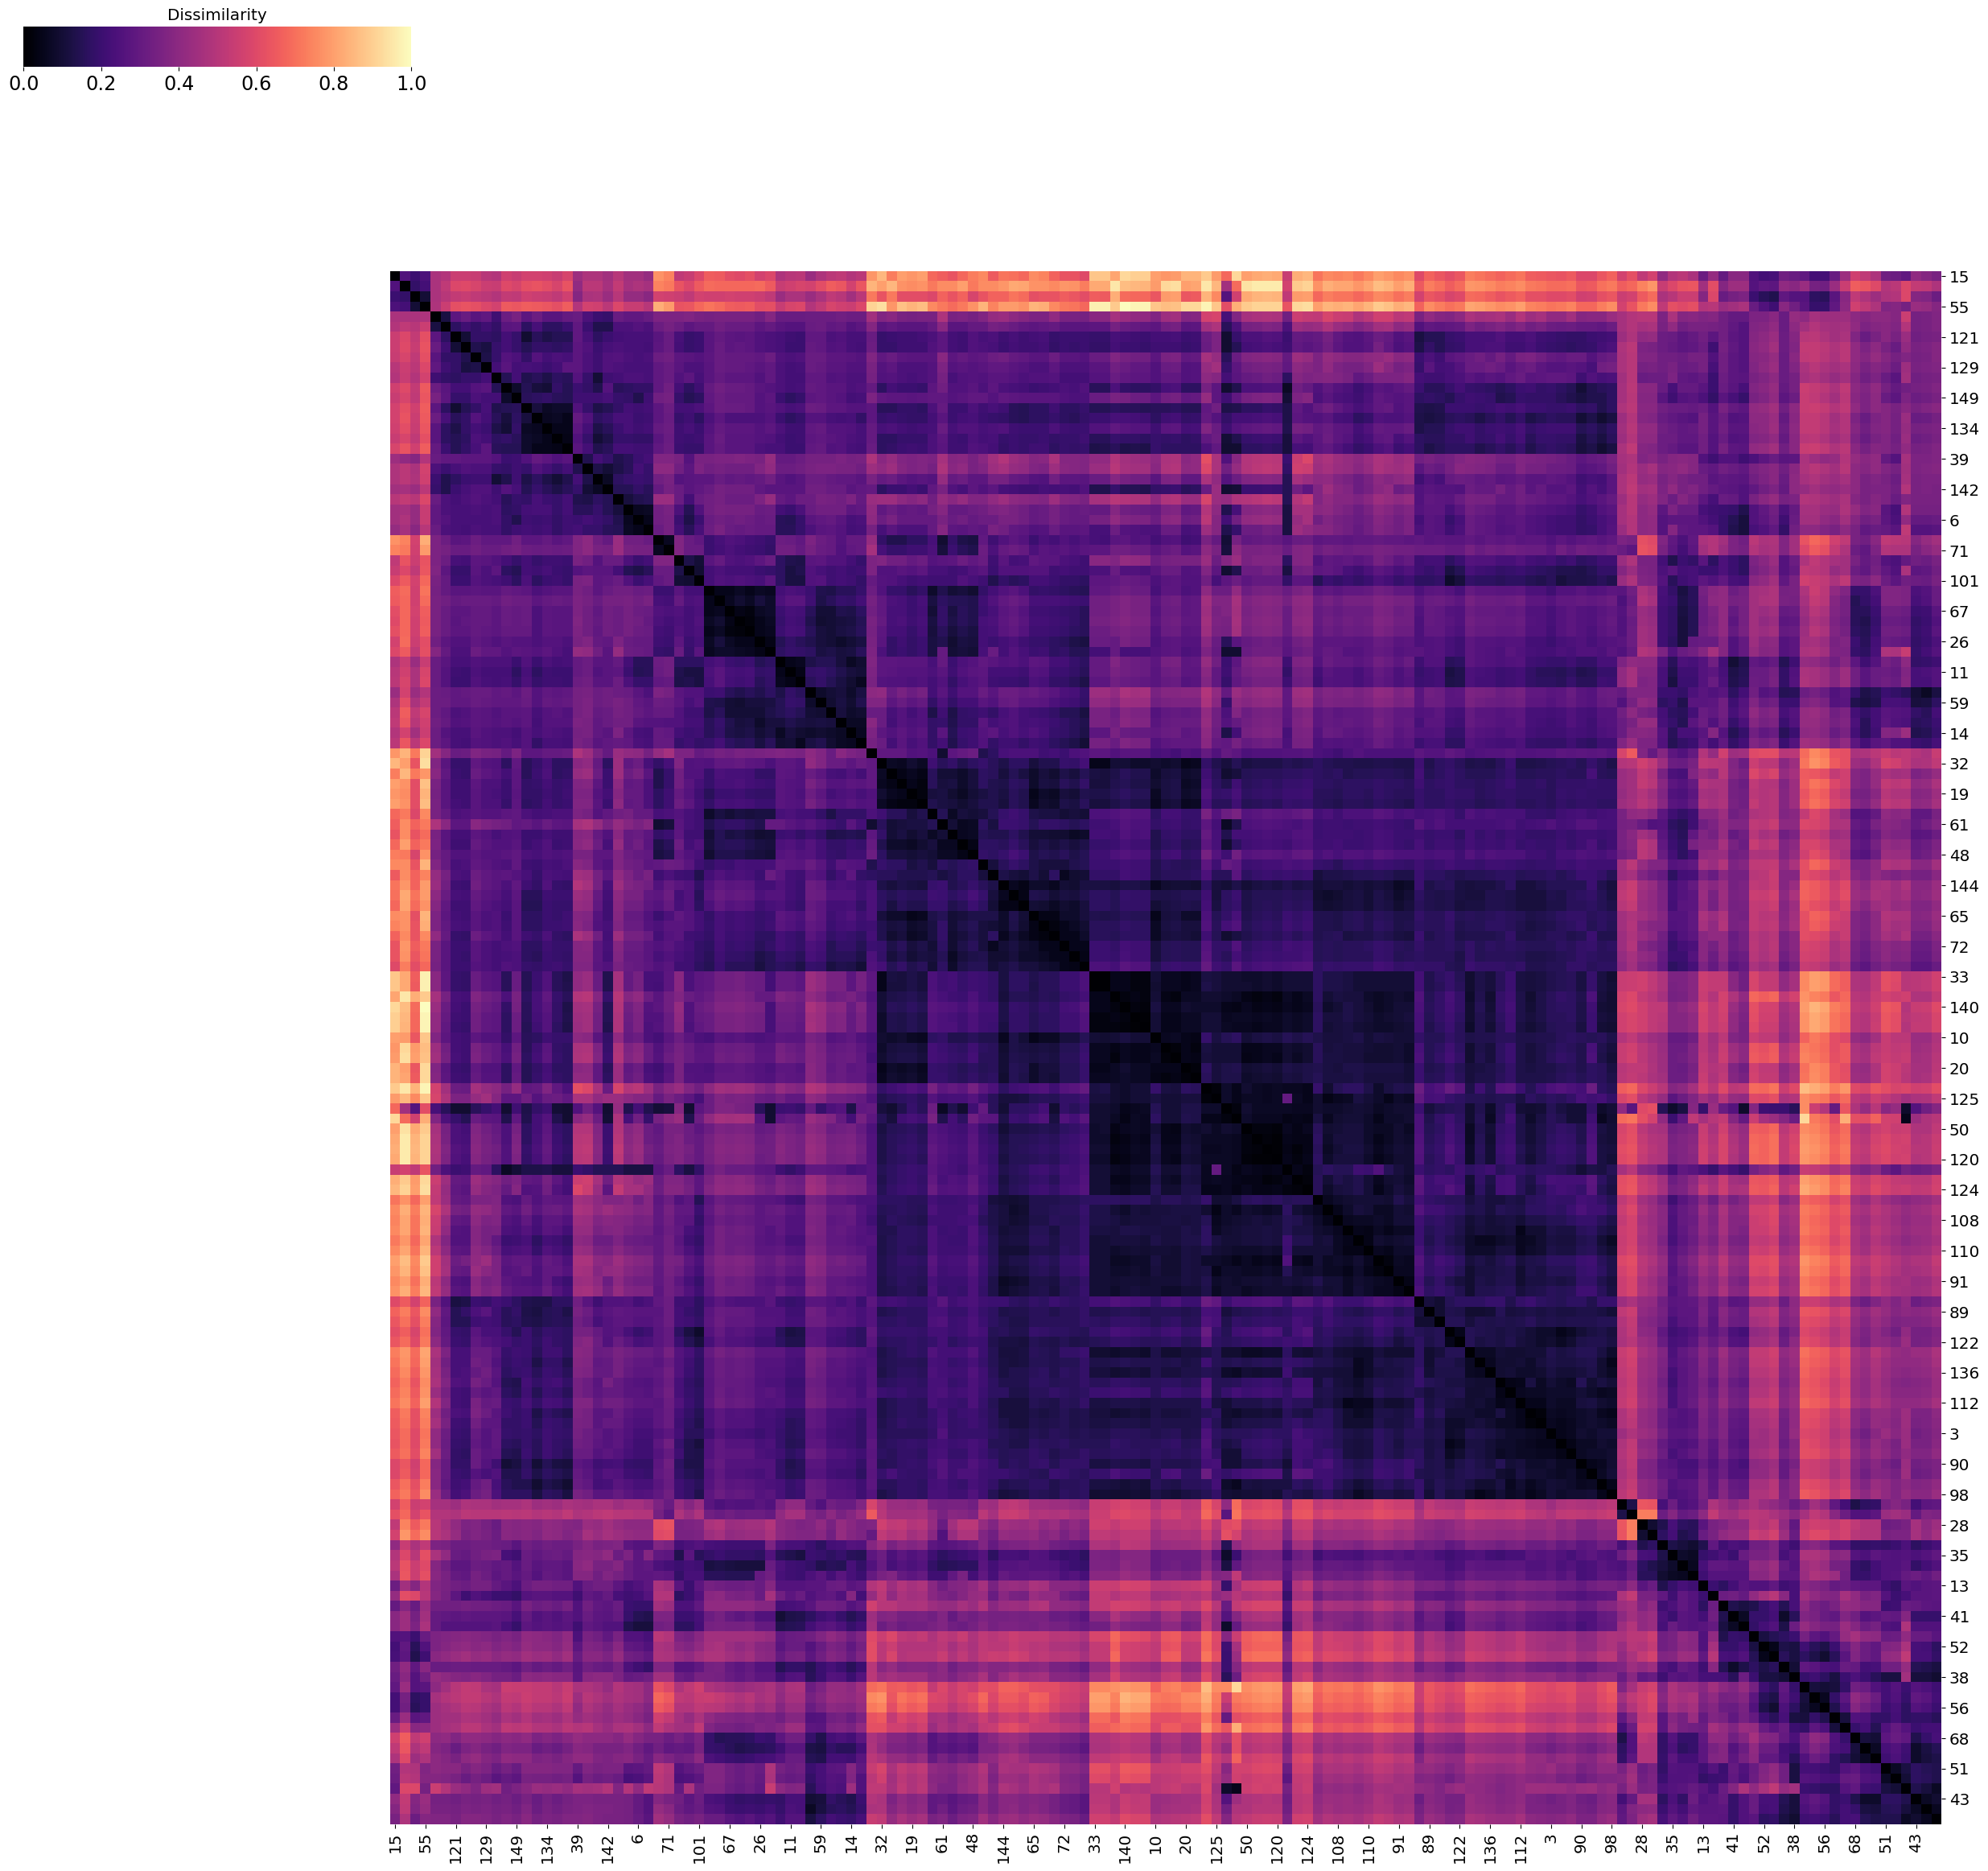

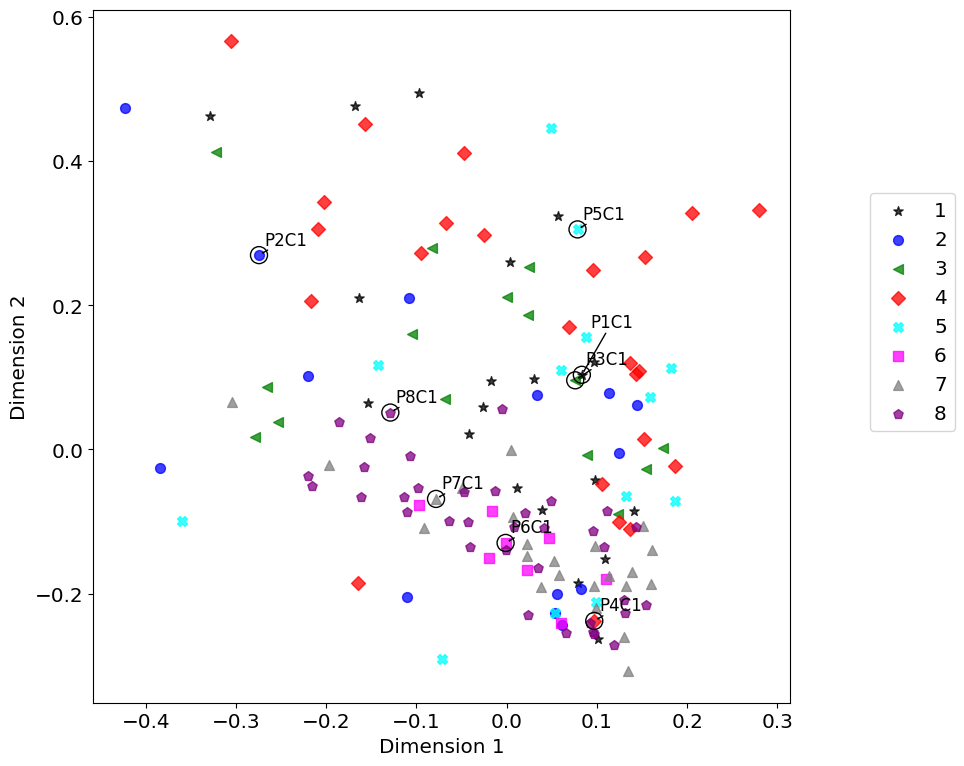

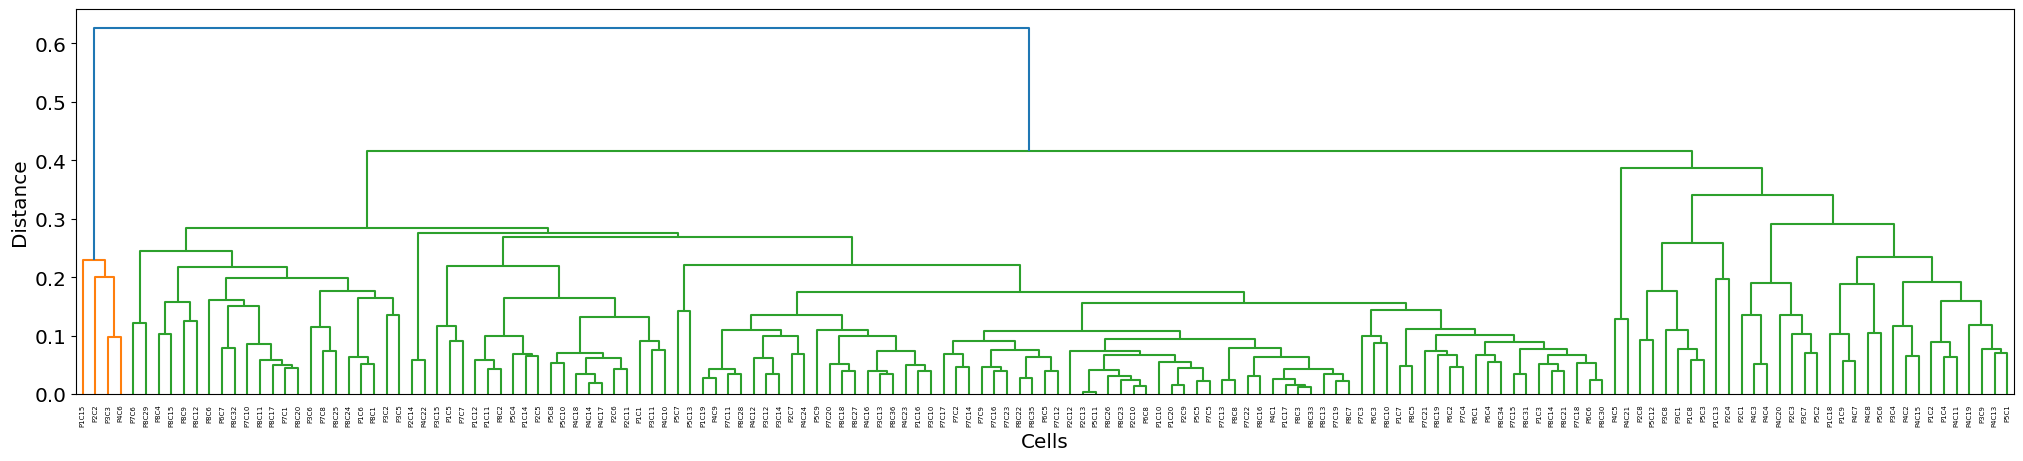

In [ ]:
data = 'experiment'
file_name = 'experimental data.xlsx'

# data = 'toy-similar'
# file_name = 'S1-40.xlsx'

# data = 'toy-similar'
# file_name = 'S2.xlsx'

# data = 'toy-dissimilar'
# file_name = 'S3.xlsx'

sheet_name = 'all plaques'
profiles_df = pd.read_excel(file_name, sheet_name, engine='openpyxl')
labels = profiles_df['Cell ID'].unique().tolist()

# without any scaling or z-normalizing the profiles
file_name = all_cells_intensities_RMSE(profiles_df, sheet_name, 4, 4)
df = pd.read_csv(file_name)
profiles_distance_matrix = cluster_map(df, figsize=(25, 25), scale=True) # scale the dissimilarity matrix

# Use MDS to visualize similarity/distance between cells
embedding = MDS(n_components=2, dissimilarity='precomputed')
data_reduced = embedding.fit_transform(profiles_distance_matrix)
plot_MDS(data_reduced, data=data, x_index=0, y_index=1)

# Dendrogram
#labels=range(1, len(profiles_distance_matrix) + 1)
labels = profiles_df['Cell ID'].unique().tolist() #[]
# for i in range(1, 5):  # P1 to P4
#     for j in range(1, 11):  # C1 to C10
#         labels.append(f'P{i}C{j}')

fig, ax = plt.subplots(figsize=(25, 5)) #25,5
profiles_distance_matrix = squareform(profiles_distance_matrix)
Z = hierarchy.linkage(profiles_distance_matrix, method='average')
hierarchy.dendrogram(Z, labels=labels, ax=ax, leaf_rotation=90) #leaf_font_size=10)
ax.set_xlabel('Cells')
ax.set_ylabel('Distance')
plt.show(fig)